In [36]:
# Core libraries
import numpy as np
import time
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# Qiskit core
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RXXGate, RYYGate, RZZGate

# IBM Runtime
from qiskit_ibm_runtime import (
    QiskitRuntimeService, 
    EstimatorV2 as Estimator,
    SamplerV2 as Sampler, 
    Session,
    Options
)

# Transpilation
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Error mitigation (new Qiskit modules)
from qiskit_ibm_runtime.options import ResilienceOptionsV2

# Classical optimization
from scipy.optimize import minimize

# Plotting
import matplotlib.pyplot as plt

print("✓ All libraries imported successfully")
print(f"  Qiskit version: {__import__('qiskit').__version__}")


✓ All libraries imported successfully
  Qiskit version: 2.1.0


In [ ]:
# ===================================================================
#                   CONFIGURATION PANEL - 3 MODES
# ===================================================================

# MODE SELECTION (choose ONE)
MODE = 'QPU'  # Options: 'IDEAL', 'FAKE', 'QPU'

# IBM Quantum credentials
IBM_CONFIG = {
    'use_fake_backend': False,          # Toggle: True=Fake (testing), False=IBM Cloud
    'api_key': "Your IBM Quantum API Key Here",
    'instance': "Your IBM Quantum Instance CRN Here",
    'backend_name': None,  # None = least_busy, or specify: "ibm_brisbane"
    'name': "Portfolio_QAOA_Run"
}

# QAOA parameters
QAOA_CONFIG = {
    'p_layers': 2,
    'shots': 3000,
    'max_iter': 40,
    'rhobeg': 1.0,
    'seed': 42
}

# Problem size
PROBLEM_CONFIG = {
    'n_assets': 5,
    'cardinality': 2
}

# Error Mitigation (FAKE y QPU)
ERROR_MITIGATION = {
    'zne': False,                    # Zero-Noise Extrapolation
    'zne_noise_factors': [1, 2, 3], # Noise amplification factors
    'dynamical_decoupling': True,   # Dynamical Decoupling
    'dd_sequence': 'XX',           # Dynamical Decoupling sequence
    'measurement_mitigation': False, # Measurement Error Mitigation
    'twirling': False,              # QPU only (does not work in AerSimulator)
    'optimization_level': 3
}


# Advanced settings
ADVANCED_CONFIG = {
    'final_shots': 8000,
    'resilience_level': 1
}

# MODE VALIDATION
assert MODE in ['IDEAL', 'FAKE', 'QPU'], "MODE must be 'IDEAL', 'FAKE', or 'QPU'"

print("="*60)
print("  QAOA WITH ERROR MITIGATION - 3 MODES")
print("="*60)
print(f"\n🔧 Mode: {MODE}")
print(f"📊 Problem: N={PROBLEM_CONFIG['n_assets']}, B={PROBLEM_CONFIG['cardinality']}")

if MODE == 'IDEAL':
    print("⚡ Ideal simulation (no noise, no error mitigation)")
elif MODE == 'FAKE':
    print("🎭 Fake backend simulation (realistic noise model)")
    print(f"🛡️  Error Mitigation:")
    print(f"   - Dynamical Decoupling: {ERROR_MITIGATION['dynamical_decoupling']}")
    print(f"   - Measurement Mitigation: {ERROR_MITIGATION['measurement_mitigation']}")
else:  # QPU
    print("🚀 Real QPU execution")
    print(f"🛡️  Error Mitigation:")
    for k, v in ERROR_MITIGATION.items():
        if k != 'optimization_level':
            print(f"   - {k}: {v}")

print("="*60)


  QAOA WITH ERROR MITIGATION - 3 MODES

🔧 Mode: QPU
📊 Problem: N=5, B=2
🚀 Real QPU execution
🛡️  Error Mitigation:
   - zne: False
   - zne_noise_factors: [1, 2, 3]
   - dynamical_decoupling: True
   - dd_sequence: XX
   - measurement_mitigation: False
   - twirling: False


In [38]:
print("\n🔗 Connecting to backend...")

if MODE == 'IDEAL':
    # ===== IDEAL: No noise =====
    from qiskit_aer import AerSimulator
    backend = AerSimulator()
    
    print(f"✓ Using IDEAL simulator (AerSimulator)")
    print(f"  Noise model: None")
    print(f"  Error rates: 0%")
    print(f"  ⚡ Fastest mode (no error mitigation needed)")

elif MODE == 'FAKE':
    # ===== FAKE: With realistic noise model =====
    from qiskit_aer import AerSimulator
    from qiskit_ibm_runtime.fake_provider import FakeMarrakesh
    from qiskit_aer.noise import NoiseModel
    
    fake_backend = FakeMarrakesh()
    noise_model = NoiseModel.from_backend(fake_backend)  # ← KEY: Extract noise
    
    backend = AerSimulator(noise_model=noise_model)  # ← Simulator WITH noise
    
    print(f"✓ Using FAKE backend with noise: {fake_backend.name}")
    print(f"  Noise model: Loaded from {fake_backend.name}")
    print(f"  Error rates: ~1-2% (realistic)")
    print(f"  Qubits available: {backend.num_qubits}")
    print(f"  🎭 Realistic simulation with error mitigation")

else:  # MODE == 'QPU'

    if IBM_CONFIG['use_fake_backend']:
        # ===== FAKE BACKEND (Testing Mode) =====
        from qiskit_ibm_runtime.fake_provider import FakeFez
        
        backend = FakeFez()
        print(f"✓ Using FAKE backend: {backend.name}")
        print(f"  🧪 Testing mode - No IBM Cloud credentials required")
        print(f"  Qubits: {backend.num_qubits}")
        print(f"  Basis gates: {backend.operation_names[:8]}...")
                
    else:  
        # ===== QPU: Real hardware =====     
        from qiskit_ibm_runtime import QiskitRuntimeService
        
        service = QiskitRuntimeService(
            channel="ibm_cloud",
            token=IBM_CONFIG['api_key'],
            instance=IBM_CONFIG['instance'],
            #name=IBM_CONFIG['name']
        )
        
        if IBM_CONFIG['backend_name']:
            backend = service.backend(IBM_CONFIG['backend_name']) 
                
        else:
            backend = service.least_busy(
                simulator=False, 
                operational=True, 
                min_num_qubits=PROBLEM_CONFIG['n_assets']
            )
        
        print(f"✓ Connected to REAL backend: {backend.name}")
        print(f"  Qubits: {backend.num_qubits}")
        print(f"  Queue: {backend.status().pending_jobs} jobs")
        print(f"  🚀 Real quantum hardware with full error mitigation")

print()


🔗 Connecting to backend...
✓ Connected to REAL backend: ibm_fez
  Qubits: 156
  Queue: 0 jobs
  🚀 Real quantum hardware with full error mitigation



In [39]:
# ============================================================================
# HELPER FUNCTIONS (Defined in QAOA_functions.qaoa_utilities)
# ============================================================================

from QAOA_functions.qaoa_utilties import qubo_to_ising, f_qubo, bitarray_from_qiskit_string
from QAOA_functions.qaoa_utilties import random_theta, build_qaoa_xy, is_valid

In [40]:
print(f"\n📊 Generating portfolio problem (NO PENALTY - XY mixer handles it)...")

n = PROBLEM_CONFIG['n_assets']
B = PROBLEM_CONFIG['cardinality']

TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA'][:n]

# VERY differentiated returns and risks
np.random.seed(42)
mu = np.array([0.20, 0.16, 0.13, 0.11, 0.25][:n])

# Different volatilities
volatilities = np.array([0.25, 0.22, 0.20, 0.18, 0.40][:n])

# Correlation matrix
correlation = 0.3 * np.ones((n, n))
np.fill_diagonal(correlation, 1.0)
Sigma = np.outer(volatilities, volatilities) * correlation

# QUBO: SOLO risk-return tradeoff (NO PENALTY!)
risk_aversion = 0.5  # Balance risk vs return

Q = np.zeros((n, n))
q = np.zeros(n)

# Risk term (positive - want to minimize)
for i in range(n):
    for j in range(n):
        Q[i, j] = risk_aversion * Sigma[i, j]

# Return term (negative - want to maximize)
for i in range(n):
    q[i] = -mu[i]  # Negative = maximize return

J, h, const_shift = qubo_to_ising(Q, q, n)

print(f"\n✓ Problem generated:")
print(f"  Assets: {n}, Cardinality: {B}")
print(f"  Valid states: {np.math.comb(n, B)}")
print(f"  Risk aversion: {risk_aversion}")
print(f"  h range: [{h.min():.4f}, {h.max():.4f}]")
print(f"  J nonzero: {np.count_nonzero(J)}")

# Test portfolios with VERY different characteristics
test_portfolios = [
    ('High Return/High Risk', [4, 0, 1, 3]),   # NVDA, AAPL, MSFT, AMZN
    ('Balanced', [0, 1, 2, 3]),                 # AAPL, MSFT, GOOGL, AMZN
    ('Low Risk/Low Return', [0, 1, 2, 3])      # AAPL, MSFT, GOOGL, AMZN    
]

print(f"\n  Test portfolios (SHOULD BE VERY DIFFERENT):")
for name, portfolio in test_portfolios:
    x_test = np.zeros(n, dtype=int)
    x_test[portfolio] = 1
    
    cost_test = x_test @ Q @ x_test + q @ x_test
    ret_test = mu[portfolio].mean()
    risk_test = np.sqrt(x_test @ Sigma @ x_test / B)
    sharpe_test = ret_test / risk_test if risk_test > 0 else 0
    
    tickers_test = [TICKERS[i] for i in portfolio]
    print(f"    {name}:")
    print(f"      Tickers: {tickers_test}")
    print(f"      QUBO cost: {cost_test:.4f}  (Return: {ret_test*100:.1f}%, Risk: {risk_test*100:.1f}%, Sharpe: {sharpe_test:.3f})")



📊 Generating portfolio problem (NO PENALTY - XY mixer handles it)...

✓ Problem generated:
  Assets: 5, Cardinality: 2
  Valid states: 10
  Risk aversion: 0.5
  h range: [0.0397, 0.0750]
  J nonzero: 10

  Test portfolios (SHOULD BE VERY DIFFERENT):
    High Return/High Risk:
      Tickers: ['NVDA', 'AAPL', 'MSFT', 'AMZN']
      QUBO cost: -0.4485  (Return: 18.0%, Risk: 52.1%, Sharpe: 0.345)
    Balanced:
      Tickers: ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
      QUBO cost: -0.4275  (Return: 15.0%, Risk: 41.5%, Sharpe: 0.361)
    Low Risk/Low Return:
      Tickers: ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
      QUBO cost: -0.4275  (Return: 15.0%, Risk: 41.5%, Sharpe: 0.361)


In [41]:
print(f"\n✓ Smart warm-start initialization:")

# Top B assets by Sharpe ratio
sharpe_individual = (252 * mu) / (np.sqrt(252 * np.diag(Sigma)) + 1e-10)
sharpe_sorted = np.argsort(-sharpe_individual)

init_bits = np.zeros(n, dtype=int)
init_bits[sharpe_sorted[:B]] = 1

print(f"  Portfolio: {[TICKERS[i] for i in sharpe_sorted[:B]]}")
print(f"  Initial cost: {init_bits @ Q @ init_bits + q @ init_bits:.2f}")
print(f"  Avg Sharpe: {sharpe_individual[sharpe_sorted[:B]].mean():.3f}")



✓ Smart warm-start initialization:
  Portfolio: ['AAPL', 'MSFT']
  Initial cost: -0.29
  Avg Sharpe: 12.122


In [42]:
# Build template circuit
P_LAYERS = QAOA_CONFIG['p_layers']
ansatz, theta_params = build_qaoa_xy(n, P_LAYERS, J, h, init_bits)

# Measurement
ansatz.measure_all()

print(f"\n✓ QAOA circuit constructed:")
print(f"  Layers: {P_LAYERS}")
print(f"  Depth: {ansatz.depth()}")
print(f"  Parameters: {len(theta_params)}")
print(f"  Gates: {sum(ansatz.count_ops().values())}")




✓ QAOA circuit constructed:
  Layers: 2
  Depth: 34
  Parameters: 4
  Gates: 58


In [43]:
# Reference: https://quantum.cloud.ibm.com/docs/en/guides/dynamical-decoupling-pass-manager
# On IBM backends Y gates are not included in the basis gates,
# so they lack duration information. Since Y and X gates are physically equivalent on IBM hardware
# (Y differs only in phase conventions), we can synthesize Y gate properties from X gate properties.
def add_y_gate_properties_to_target(backend):
    """
    Add Y gate properties to backend target by deriving from X gates.

    Solves: TranspilerError: 'Duration of y on qubits [n] is not found.'

    Reference:
    - https://quantum.cloud.ibm.com/docs/en/guides/dynamical-decoupling-pass-manager

    Args:
        backend: Qiskit backend object

    Returns:
        True if successful, False otherwise
    """
    from qiskit.transpiler import InstructionProperties

    # Check if Y gate already exists in target
    if 'y' in backend.target.operation_names:
        print("  ℹ️  Y gate already in backend target - no synthesis needed")
        return True

    # Extract X gate properties and add Y gates with same properties
    try:
        # Get X gate instruction properties (iterate through available qargs)
        x_instruction_properties = backend.target["x"]
        
        if not x_instruction_properties:
            print("  ❌ X gate properties not found in backend target")
            return False

        # Copy X gate properties to Y gate
        # This preserves the qubit-specific properties from X gates
        y_gate_properties = {}
        
        for qargs, x_props in x_instruction_properties.items():
            # Create Y gate properties with same duration and error as X gate
            if x_props is not None:
                y_gate_properties[qargs] = InstructionProperties(
                    duration=x_props.duration,
                    error=x_props.error
                )
            else:
                y_gate_properties[qargs] = None

        # Add Y gate instruction to target with properties matching X gates
        backend.target.add_instruction(YGate(), y_gate_properties)

        print(f"  ✓ Y gate properties synthesized from X gates ({len(y_gate_properties)} qargs)")
        return True
        
    except Exception as e:
        print(f"  ❌ Failed to synthesize Y gate properties: {e}")
        import traceback
        traceback.print_exc()
        return False


In [44]:
print("\n⚙️  Transpiling with error mitigation...")

if MODE == 'IDEAL':
    # ===== IDEAL: Simple transpilation without DD =====
    from qiskit import transpile
    
    transpiled_ansatz = transpile(
        ansatz,
        backend=backend,
        optimization_level=ERROR_MITIGATION['optimization_level'],
        seed_transpiler=QAOA_CONFIG['seed']
    )
    
    print("✓ Transpilation complete (no noise, no error mitigation)")

elif MODE == 'FAKE':
    # ===== FAKE: Transpilation with noise model (WITHOUT DD) =====
    from qiskit import transpile
    
    transpiled_ansatz = transpile(
        ansatz,
        backend=backend,
        optimization_level=ERROR_MITIGATION['optimization_level'],
        seed_transpiler=QAOA_CONFIG['seed']
    )
    
    print("✓ Transpilation complete with noise model")
    print("  Note: Noise model active (gate errors, readout errors)")
    print("  DD not applied in simulation mode (not needed)")

else:  # MODE == 'QPU'
    # ===== QPU: Full transpilation with DD =====
    pm = generate_preset_pass_manager(
        optimization_level=ERROR_MITIGATION['optimization_level'],
        target=backend.target
    )
    
    transpiled_ansatz = pm.run(ansatz)
    
    # Add Dynamical Decoupling
    if ERROR_MITIGATION['dynamical_decoupling']:
    # Inserts pulses during idle times to suppress decoherence.
    # Reference: https://quantum.cloud.ibm.com/docs/en/guides/dynamical-decoupling-pass-manager

        from qiskit.transpiler import PassManager
        from qiskit.transpiler.passes import ALAPScheduleAnalysis, PadDynamicalDecoupling
        from qiskit.circuit.library import XGate, YGate
        
        add_y_gate_properties_to_target(backend)
        
        # Define DD sequence
        if ERROR_MITIGATION['dd_sequence'] == 'XY4':
            dd_sequence = [XGate(), YGate(), XGate(), YGate()]
        elif ERROR_MITIGATION['dd_sequence'] == 'XX':
            dd_sequence = [XGate(), XGate()]
        else:
            dd_sequence = [XGate()]
        
        # dd_pm = PassManager([
        #     ALAPScheduleAnalysis(backend.target),
        #     PadDynamicalDecoupling(backend.target, dd_sequence)
        # ])
            
        dd_pm = PassManager([
        ALAPScheduleAnalysis(backend.target.durations()),
        PadDynamicalDecoupling(backend.target.durations(), dd_sequence)
    ])
        
        transpiled_ansatz = dd_pm.run(transpiled_ansatz)
        print("  ✅ Dynamical Decoupling (XY4) applied")
    
    print(f"✓ Transpilation complete with full error mitigation")

print(f"  Transpiled depth: {transpiled_ansatz.depth()}")
print(f"  Parameters preserved: {len(transpiled_ansatz.parameters)}")


⚙️  Transpiling with error mitigation...


  ✓ Y gate properties synthesized from X gates (156 qargs)
  ✅ Dynamical Decoupling (XY4) applied
✓ Transpilation complete with full error mitigation
  Transpiled depth: 384
  Parameters preserved: 4


In [45]:
# Configure IBM Runtime options with error mitigation
from qiskit_ibm_runtime.options import SamplerOptions

options = SamplerOptions()

# ===================================================================
# ERROR MITIGATION/SUPPRESSION FOR SAMPLERV2
# ===================================================================
# Note: SamplerV2 does NOT support resilience options (those are Estimator-only)
# Available techniques: Gate Twirling, and ZNE (custom)
# DD is already applied during local transpilation, so we disable it here to avoid conflicts

# Gate Twirling (Error Suppression) - Available in qiskit_ibm_runtime >= 0.23.0
if ERROR_MITIGATION['twirling']:
    if IBM_CONFIG['use_fake_backend']:
        print("⚠️  Gate Twirling: Skipped on fake backend (Runtime feature only)")
    else:
        try:
            options.twirling.enable_gates = True
            print("✓ Gate Twirling enabled")
        except Exception as e:
            print(f"⚠️  Gate Twirling: Failed to enable ({type(e).__name__})")

# Execution options
options.default_shots = QAOA_CONFIG['shots']


print(f"\n✓ SamplerV2 options configured")


✓ SamplerV2 options configured


In [46]:
print("\n" + "="*60)
print("  QAOA OPTIMIZATION")
print("="*60)

rng = np.random.default_rng(QAOA_CONFIG['seed'])
t_start = time.time()
iteration = [0]
cost_history = []

if MODE in ['IDEAL', 'FAKE']:
    # ===== IDEAL and FAKE using AerSampler =====
    from qiskit_aer.primitives import Sampler as AerSampler
    sampler = AerSampler()
    
    def objective_func(theta: np.ndarray) -> float:
        """Objective function for IDEAL/FAKE modes."""
        param_values = {theta_params[i]: theta[i] for i in range(len(theta_params))}
        
        bound_circuit = transpiled_ansatz.assign_parameters(param_values)
        job = sampler.run([bound_circuit], shots=QAOA_CONFIG['shots'])
        result = job.result()
        pub_result = result.quasi_dists[0]
        
        total_cost, valid = 0.0, 0
        for bitstring_int, prob in pub_result.items():
            bitstring = format(bitstring_int, f'0{n}b')
            x = bitarray_from_qiskit_string(bitstring)
            count = int(prob * QAOA_CONFIG['shots'])
            
            if is_valid(x, B):
                total_cost += count * f_qubo(x, Q, q)
                valid += count
        
        if valid == 0:
            return 1e9
        
        avg_cost = total_cost / valid
        cost_history.append(avg_cost)
        iteration[0] += 1
        
        if iteration[0] % 10 == 0:
            print(f"  Iter {iteration[0]:2d}: {avg_cost:.3f}")
        
        return avg_cost

else:  # MODE == 'QPU'
    # ===== QPU REAL with full error mitigation =====
    
    if IBM_CONFIG['use_fake_backend']:
        # Use Qiskit Aer simulator for fake backends
        from qiskit_aer.primitives import SamplerV2 as AerSamplerV2   
        sampler = AerSamplerV2(
            default_shots=QAOA_CONFIG['shots'],
            options={'backend_options': {'method': 'automatic'}}
        )
        session = Session(backend=backend)
        print("✓ Using Aer Simulator with FakeFez error model (fake backend mode)")
        
    else:
        # Use IBM Runtime sampler for real backends
        from qiskit_ibm_runtime import SamplerV2 as IBMSamplerV2
      
        # options = Options()
        # options.execution.shots = QAOA_CONFIG['shots']
        # options.optimization_level = ERROR_MITIGATION['optimization_level']
        print("✓ Using IBM Runtime Sampler (real backend mode)")
     
    gates_in_circuit = set(transpiled_ansatz.count_ops().keys())
    print(f"Gates in transpiled circuit: {gates_in_circuit}")  
        
    # Enable measurement error mitigation
    if ERROR_MITIGATION['measurement_mitigation']:
        #options.resilience.measure_mitigation = True
        print("  ✅ Measurement mitigation enabled")
    
    # Enable twirling (solo QPU)
    if ERROR_MITIGATION['twirling']:
        options.twirling.enable_gates = True
        options.twirling.enable_measure = True
        print("  ✅ Twirling enabled")
    
    if ERROR_MITIGATION['zne']:
        class ZeroNoiseExtrapolator:
            """
            Implements Zero-Noise Extrapolation (ZNE).
            Runs circuit with amplified noise and extrapolates to zero.
            """
            def __init__(self):
                self.noise_factors = ERROR_MITIGATION['zne_noise_factors']
                self.enabled = ERROR_MITIGATION['zne']
            
            def amplify_noise(self, circuit: QuantumCircuit, factor: int) -> QuantumCircuit:
                """
                Amplify noise by folding gates (insert U†U pairs).
                """
                if factor == 1:
                    return circuit
                
                # Simple global folding: repeat entire circuit (factor-1) times
                folded = circuit.copy()
                for _ in range(factor - 1):
                    folded.compose(circuit.inverse(), inplace=True)
                    folded.compose(circuit, inplace=True)
                
                return folded
            
            def extrapolate(self, noise_factors: List[int], 
                        expectation_values: List[float]) -> float:
                """
                Extrapolate to zero noise using polynomial fit.
                """
                # Linear extrapolation (can use polynomial for better fit)
                coeffs = np.polyfit(noise_factors, expectation_values, deg=1)
                return np.polyval(coeffs, 0)  # Evaluate at noise=0

        zne = ZeroNoiseExtrapolator(ERROR_MITIGATION['zne_noise_factors'])
    
    if not IBM_CONFIG['use_fake_backend']:
        sampler = IBMSamplerV2(mode=backend, options=options)
    
    def objective_func(theta: np.ndarray) -> float:
        """
        Objective function  for QPU mode. With optional Zero-Noise Extrapolation.
        """
        # Bind parameters
        param_values = {theta_params[i]: theta[i] for i in range(len(theta_params))}

        if ERROR_MITIGATION['zne']:
            # Run with multiple noise levels
            circuits = []
            for factor in zne.noise_factors:
                bound_circuit = transpiled_ansatz.assign_parameters(param_values)
                if factor > 1:
                    bound_circuit = zne.amplify_noise(bound_circuit, factor)
                circuits.append(bound_circuit)
            
            # Execute all noise levels
            job = sampler.run(circuits, shots=QAOA_CONFIG['shots'])
            results = job.result()
            
            # Compute expectation values for each noise level
            expectation_values = []
            for result in results:
                counts = result.data.meas.get_counts()
                total_cost, valid = 0.0, 0
                for bitstring, count in counts.items():
                    x = bitarray_from_qiskit_string(bitstring)
                    if is_valid(x, B):
                        total_cost += count * f_qubo(x, Q, q)
                        valid += count
                
                if valid == 0:
                    expectation_values.append(1e6)
                else:
                    expectation_values.append(total_cost / valid)
            
            # Extrapolate to zero noise
            avg_cost = zne.extrapolate(zne.noise_factors, expectation_values)
        
        else:
            # Standard execution (no ZNE)
            bound_circuit = transpiled_ansatz.assign_parameters(param_values)
            job = sampler.run([bound_circuit], shots=QAOA_CONFIG['shots'])
            result = job.result()[0]
            counts = result.data.meas.get_counts()
            
            total_cost, valid = 0.0, 0
            for bitstring, count in counts.items():
                x = bitarray_from_qiskit_string(bitstring)
                if is_valid(x, B):
                    total_cost += count * f_qubo(x, Q, q)
                    valid += count
            
            if valid == 0:
                return 1e9
            
            avg_cost = total_cost / valid
    
        cost_history.append(avg_cost)
        iteration[0] += 1
        
        if iteration[0] % 10 == 0:
            zne_tag = " [ZNE]" if ERROR_MITIGATION['zne'] else ""
            print(f"  Iter {iteration[0]:2d}: {avg_cost:.5f}{zne_tag}")
        
        return avg_cost

# ===== OPTIMIZATION (common for all 3 modes) =====
x0 = random_theta(2*P_LAYERS, rng)

print(f"\nStarting COBYLA optimization...")
print(f"  Initial parameters: {len(x0)} values")
print(f"  Max iterations: {QAOA_CONFIG['max_iter']}")

result = minimize(
    objective_func, x0, method='COBYLA',
    options={'maxiter': QAOA_CONFIG['max_iter'], 'rhobeg': QAOA_CONFIG['rhobeg']}
)

best_theta = result.x
best_cost = result.fun

# Cleanup for QPU
if MODE == 'QPU':
    #session.close()
    print("  ✓ QPU session closed")

t_opt = time.time() - t_start

print(f"\n✓ Optimization complete in {t_opt:.1f}s")
print(f"  Best cost: {best_cost:.3f}")
print(f"  Iterations: {len(cost_history)}")
print(f"  Mode: {MODE}")


  QAOA OPTIMIZATION
✓ Using IBM Runtime Sampler (real backend mode)
Gates in transpiled circuit: {'x', 'cz', 'measure', 'sx', 'barrier', 'delay', 'rz'}

Starting COBYLA optimization...
  Initial parameters: 8 values
  Max iterations: 40
  Iter 10: -0.27188
  Iter 20: -0.29529
  Iter 30: -0.30211
  Iter 40: -0.30146
  ✓ QPU session closed

✓ Optimization complete in 242.2s
  Best cost: -0.303
  Iterations: 40
  Mode: QPU


In [47]:
print("\n📊 Final sampling...")

if MODE == 'FAKE' or MODE == 'IDEAL':
    from qiskit_aer.primitives import Sampler as AerSampler
    sampler = AerSampler()
    param_values = {theta_params[i]: best_theta[i] for i in range(len(theta_params))}
    final_circuit = transpiled_ansatz.assign_parameters(param_values)
    job = sampler.run([final_circuit], shots=ADVANCED_CONFIG['final_shots'])
    result = job.result()
    pub_result = result.quasi_dists[0]
    counts = {}
    for bitstring_int, prob in pub_result.items():
        bitstring = format(bitstring_int, f'0{n}b')
        counts[bitstring] = int(prob * ADVANCED_CONFIG['final_shots'])
else:
    if IBM_CONFIG['use_fake_backend']:
        # Use Qiskit Aer simulator for fake backends
        from qiskit_aer.primitives import SamplerV2 as AerSamplerV2   
        sampler = AerSamplerV2(
            default_shots=QAOA_CONFIG['shots'],
            options={'backend_options': {'method': 'automatic'}}
        )
        print("✓ Using Aer Simulator with FakeFez error model (fake backend mode)")
        
    else:
        # Use IBM Runtime sampler for real backends
        # from qiskit_ibm_runtime import SamplerV2 as IBMSamplerV2
        # sampler = IBMSamplerV2(mode=backend, options=options)
        options = Options()
        # options.execution.shots = QAOA_CONFIG['shots']
        # options.resilience_level = ADVANCED_CONFIG['resilience_level']
        # print("✓ Using IBM Runtime Sampler (real backend mode)")
    
    
    if ERROR_MITIGATION['measurement_mitigation']:
        options.resilience.measure_mitigation = True
    if ERROR_MITIGATION['twirling']:
        options.twirling.enable_gates = True
        options.twirling.enable_measure = True

    param_values = {theta_params[i]: best_theta[i] for i in range(len(theta_params))}
    final_circuit = transpiled_ansatz.assign_parameters(param_values)
    # session = Session(backend=backend)
    # sampler = Sampler(session=session, options=options)
    job = sampler.run([final_circuit])
    result = job.result()
    counts = result[0].data.meas.get_counts()
    # session.close()

valid_solutions = []
for bitstring, count in counts.items():
    x = bitarray_from_qiskit_string(bitstring)
    if is_valid(x, B):
        cost = f_qubo(x, Q, q)
        valid_solutions.append((bitstring, count, cost, x))

valid_solutions.sort(key=lambda t: t[2])

if valid_solutions:
    s_best, c_best, fx_best, x_best = valid_solutions[0]
    sel_idx = np.where(x_best == 1)[0]
    sel_tickers = [TICKERS[i] for i in sel_idx]
    
    # CORRECCIÓN: Calcular métricas correctamente
    w = np.zeros(n)
    w[sel_idx] = 1.0 / B
    
    # mu y volatilities ya están en términos anualizados
    mu_portfolio = float(mu[sel_idx].mean())  # Promedio de retornos
    vol_portfolio = float(volatilities[sel_idx].mean())  # Promedio de volatilidades
    sharpe = mu_portfolio / vol_portfolio if vol_portfolio > 1e-6 else 0.0
    
    print(f"\n{'='*60}")
    print("  QAOA RESULTS")
    print(f"{'='*60}")
    print(f"Portfolio: {', '.join(sel_tickers)}")
    print(f"\n📈 Performance:")
    print(f"  QUBO cost: {fx_best:.4f}")
    print(f"  Avg Return: {mu_portfolio*100:.2f}%")
    print(f"  Avg Volatility: {vol_portfolio*100:.2f}%")
    print(f"  Sharpe Ratio: {sharpe:.3f}")
    print(f"\n📊 Measurement Stats:")
    print(f"  Best solution freq: {c_best}/{ADVANCED_CONFIG['final_shots']} ({c_best/ADVANCED_CONFIG['final_shots']*100:.2f}%)")
    valid_total = sum(s[1] for s in valid_solutions)
    print(f"  Valid solutions: {valid_total}/{ADVANCED_CONFIG['final_shots']} ({valid_total/ADVANCED_CONFIG['final_shots']*100:.1f}%)")
    print(f"  Unique costs: {len(set([s[2] for s in valid_solutions]))}")
    
    # Top 5 solutions
    print(f"\n🏆 Top 5 Solutions:")
    for i, (bs, cnt, cst, x_sol) in enumerate(valid_solutions[:5]):
        idx_sol = np.where(x_sol == 1)[0]
        tick_sol = [TICKERS[j] for j in idx_sol]
        freq_pct = cnt / ADVANCED_CONFIG['final_shots'] * 100
        print(f"  {i+1}. {tick_sol}")
        print(f"     Cost: {cst:.4f}, Freq: {cnt} ({freq_pct:.2f}%)")
else:
    print("❌ No valid solutions")



📊 Final sampling...

  QAOA RESULTS
Portfolio: AAPL, NVDA

📈 Performance:
  QUBO cost: -0.3087
  Avg Return: 22.50%
  Avg Volatility: 32.50%
  Sharpe Ratio: 0.692

📊 Measurement Stats:
  Best solution freq: 1810/8000 (22.62%)
  Valid solutions: 2054/8000 (25.7%)
  Unique costs: 10

🏆 Top 5 Solutions:
  1. ['AAPL', 'NVDA']
     Cost: -0.3087, Freq: 1810 (22.62%)
  2. ['AAPL', 'MSFT']
     Cost: -0.2880, Freq: 41 (0.51%)
  3. ['MSFT', 'NVDA']
     Cost: -0.2794, Freq: 27 (0.34%)
  4. ['AAPL', 'GOOGL']
     Cost: -0.2638, Freq: 36 (0.45%)
  5. ['GOOGL', 'NVDA']
     Cost: -0.2560, Freq: 35 (0.44%)


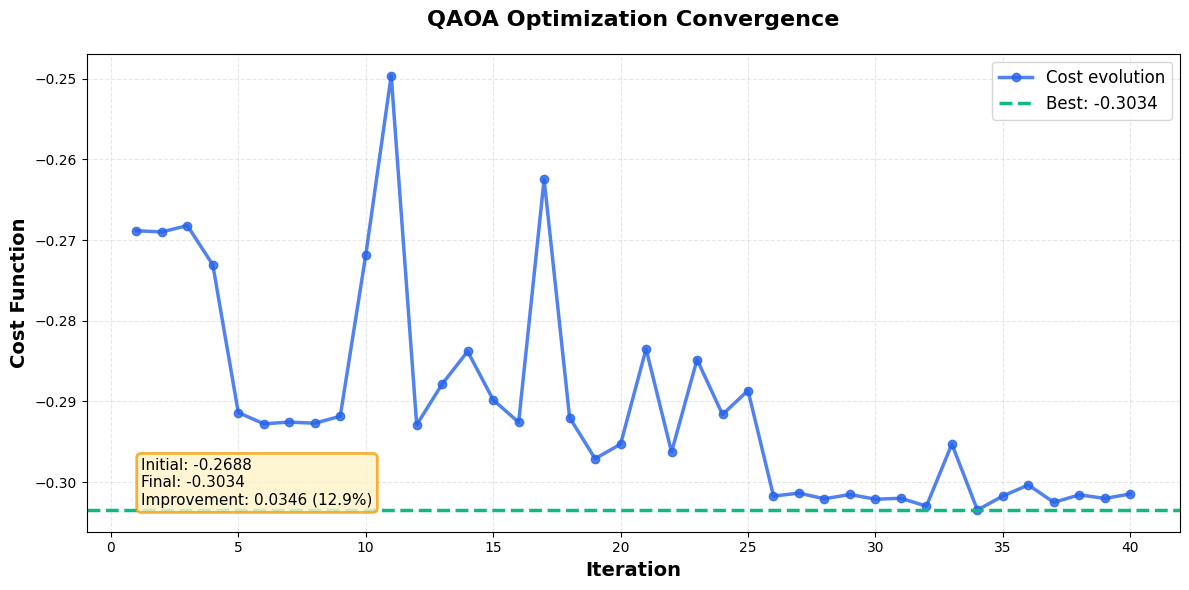

✓ Convergence: 40 iterations, improvement: 0.0346


In [48]:
fig, ax = plt.subplots(figsize=(12, 6))

# Plot convergencia
iterations = range(1, len(cost_history)+1)
ax.plot(iterations, cost_history, 
        marker='o', markersize=6, linewidth=2.5, alpha=0.8, 
        color='#2563eb', label='Cost evolution')

# Línea del mejor valor
ax.axhline(y=best_cost, color='#10b981', linestyle='--', 
           linewidth=2.5, label=f'Best: {best_cost:.4f}')

# Calcular mejora
if len(cost_history) > 0:
    improvement = abs(cost_history[0] - best_cost)
    improvement_pct = (improvement / abs(cost_history[0])) * 100
    ax.text(0.05, 0.05, 
            f'Initial: {cost_history[0]:.4f}\nFinal: {best_cost:.4f}\nImprovement: {improvement:.4f} ({improvement_pct:.1f}%)', 
            transform=ax.transAxes, fontsize=11, verticalalignment='bottom',
            bbox=dict(boxstyle='round', facecolor='#fef3c7', alpha=0.8, edgecolor='#f59e0b', linewidth=2))

ax.set_xlabel('Iteration', fontsize=14, fontweight='bold')
ax.set_ylabel('Cost Function', fontsize=14, fontweight='bold')
ax.set_title('QAOA Optimization Convergence', fontsize=16, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=12, loc='upper right')
plt.tight_layout()
plt.show()

print(f"✓ Convergence: {len(cost_history)} iterations, improvement: {improvement:.4f}")


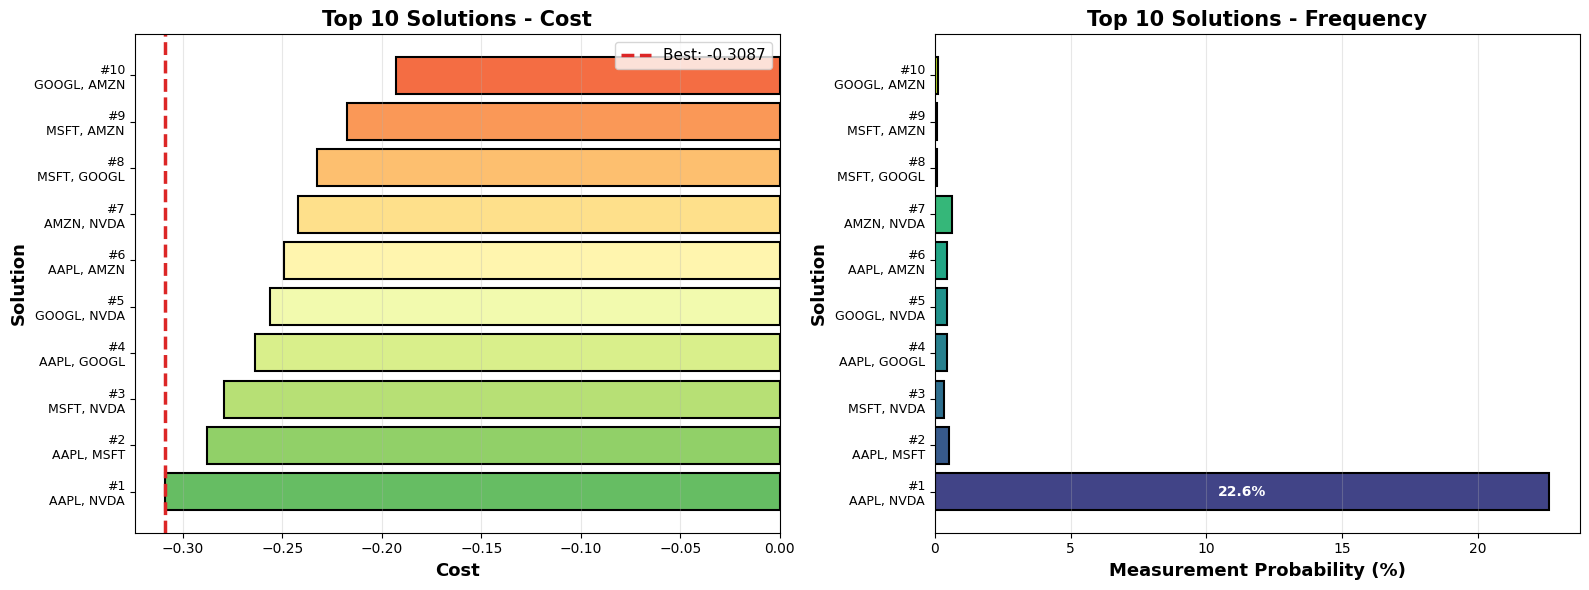

✓ Top solution dominance: 22.62% of measurements


In [49]:
top_10 = valid_solutions[:min(10, len(valid_solutions))]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Costs
labels = []
costs = []
for i, (bs, cnt, cst, x_sol) in enumerate(top_10):
    idx_sol = np.where(x_sol == 1)[0]
    tick_sol = [TICKERS[j] for j in idx_sol]
    labels.append(f"#{i+1}\n{', '.join(tick_sol)}")
    costs.append(cst)

y_pos = np.arange(len(labels))
colors_cost = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(top_10)))

bars1 = ax1.barh(y_pos, costs, color=colors_cost, edgecolor='black', linewidth=1.5)
ax1.axvline(x=fx_best, color='#dc2626', linestyle='--', linewidth=2.5, label=f'Best: {fx_best:.4f}')
ax1.set_xlabel('Cost', fontsize=13, fontweight='bold')
ax1.set_ylabel('Solution', fontsize=13, fontweight='bold')
ax1.set_yticks(y_pos)
ax1.set_yticklabels(labels, fontsize=9)
ax1.set_title('Top 10 Solutions - Cost', fontsize=15, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, axis='x')

# Subplot 2: Frequencies
freqs = [s[1]/ADVANCED_CONFIG['final_shots']*100 for s in top_10]
colors_freq = plt.cm.viridis(np.linspace(0.2, 0.9, len(top_10)))

bars2 = ax2.barh(y_pos, freqs, color=colors_freq, edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Measurement Probability (%)', fontsize=13, fontweight='bold')
ax2.set_ylabel('Solution', fontsize=13, fontweight='bold')
ax2.set_yticks(y_pos)
ax2.set_yticklabels(labels, fontsize=9)
ax2.set_title('Top 10 Solutions - Frequency', fontsize=15, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

# Añadir valores en las barras
for i, (bar, val) in enumerate(zip(bars2, freqs)):
    if val > 5:  # Solo mostrar si >5%
        ax2.text(val/2, bar.get_y() + bar.get_height()/2, 
                f'{val:.1f}%', ha='center', va='center', 
                fontsize=10, fontweight='bold', color='white')

plt.tight_layout()
plt.show()

print(f"✓ Top solution dominance: {freqs[0]:.2f}% of measurements")


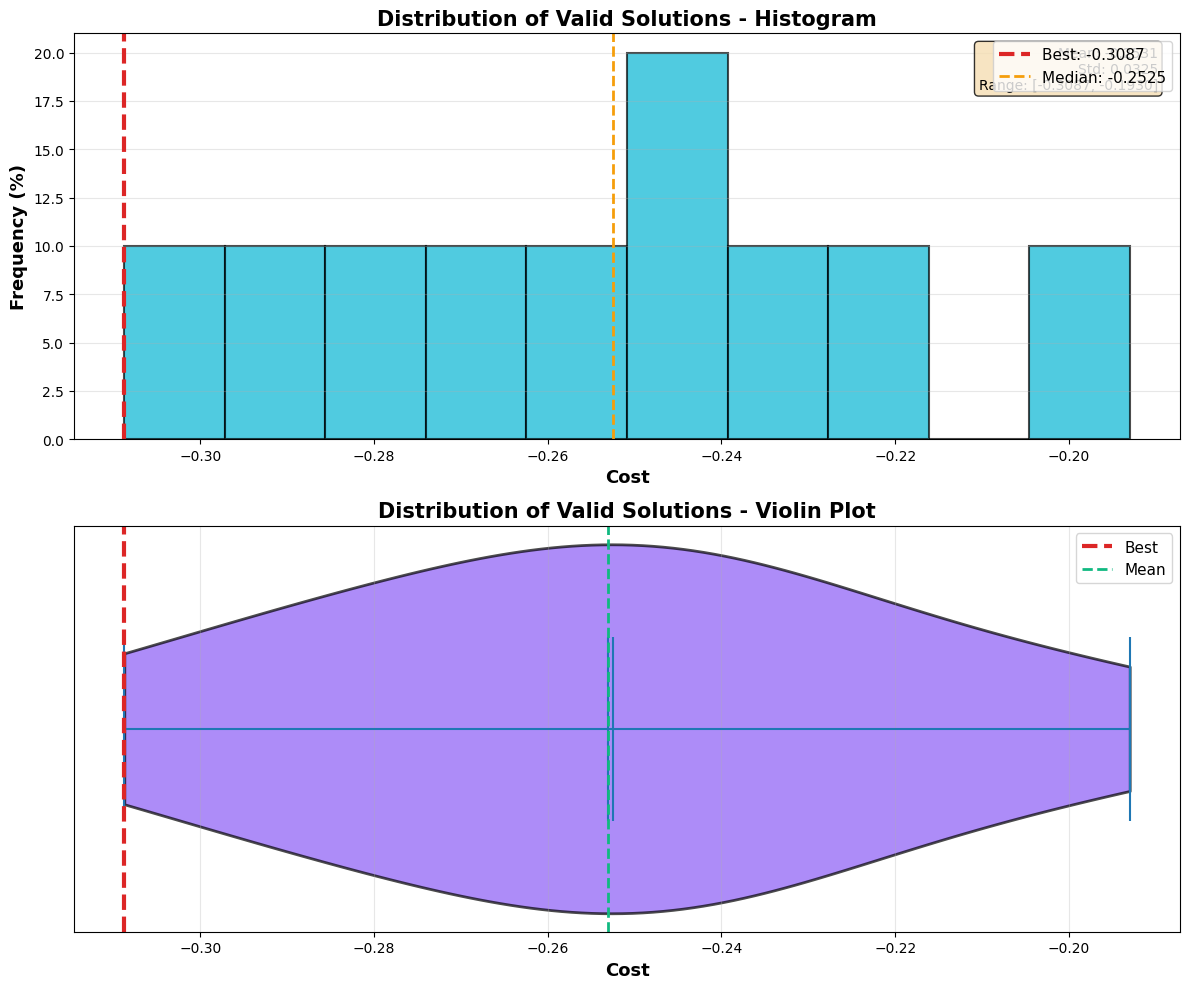

✓ Cost distribution: 10 unique values


In [50]:
costs_all = [s[2] for s in valid_solutions]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Histograma
n_bins = min(30, len(set(costs_all)))
ax1.hist(costs_all, bins=n_bins, color='#06b6d4', edgecolor='black', 
         alpha=0.7, linewidth=1.5, weights=np.ones(len(costs_all))/len(costs_all)*100)
ax1.axvline(x=fx_best, color='#dc2626', linestyle='--', 
            linewidth=3, label=f'Best: {fx_best:.4f}')
ax1.axvline(x=np.median(costs_all), color='#f59e0b', linestyle='--', 
            linewidth=2, label=f'Median: {np.median(costs_all):.4f}')
ax1.set_xlabel('Cost', fontsize=13, fontweight='bold')
ax1.set_ylabel('Frequency (%)', fontsize=13, fontweight='bold')
ax1.set_title('Distribution of Valid Solutions - Histogram', 
              fontsize=15, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')

# Añadir estadísticas
stats_text = f'Mean: {np.mean(costs_all):.4f}\nStd: {np.std(costs_all):.4f}\nRange: [{min(costs_all):.4f}, {max(costs_all):.4f}]'
ax1.text(0.98, 0.97, stats_text, transform=ax1.transAxes, 
         fontsize=10, verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Violin plot
parts = ax2.violinplot([costs_all], vert=False, widths=0.7,
                       showmeans=True, showmedians=True, showextrema=True)
for pc in parts['bodies']:
    pc.set_facecolor('#8b5cf6')
    pc.set_alpha(0.7)
    pc.set_edgecolor('black')
    pc.set_linewidth(2)

ax2.axvline(x=fx_best, color='#dc2626', linestyle='--', linewidth=3, label='Best')
ax2.axvline(x=np.mean(costs_all), color='#10b981', linestyle='--', linewidth=2, label='Mean')
ax2.set_xlabel('Cost', fontsize=13, fontweight='bold')
ax2.set_title('Distribution of Valid Solutions - Violin Plot', 
              fontsize=15, fontweight='bold')
ax2.set_yticks([])
ax2.legend(fontsize=11, loc='upper right')
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print(f"✓ Cost distribution: {len(set(costs_all))} unique values")


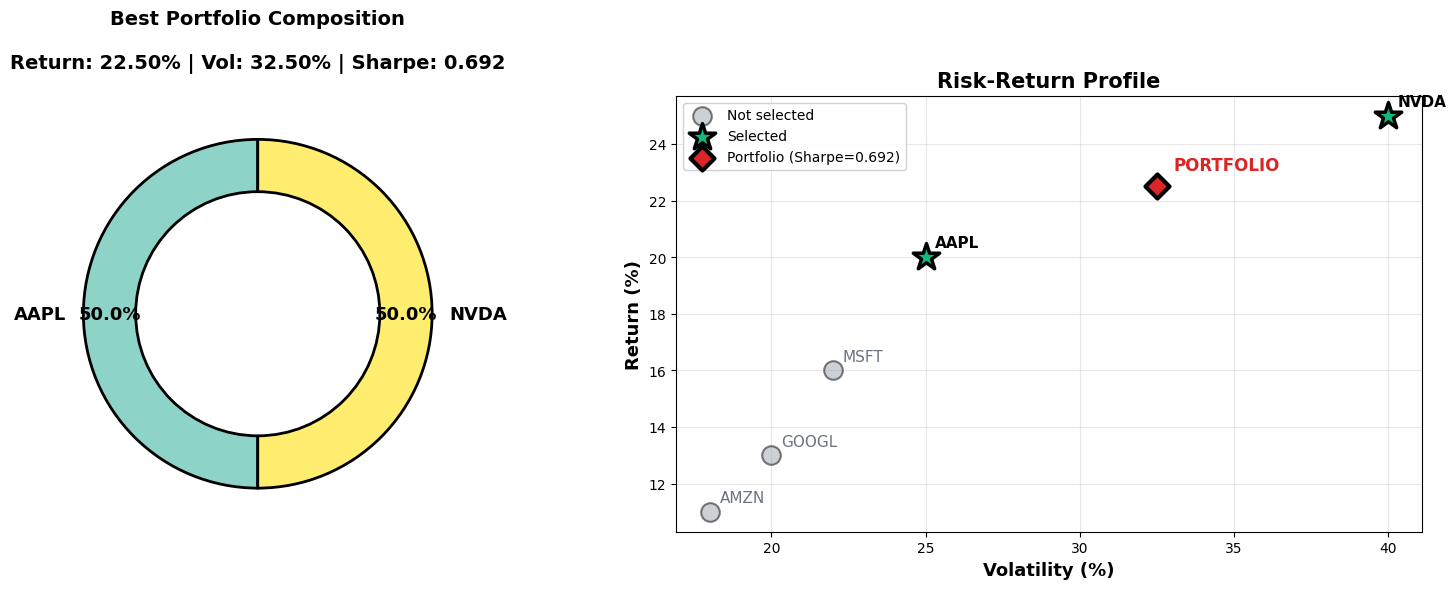

✓ Portfolio: 2 assets selected


In [51]:
fig = plt.figure(figsize=(16, 6))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])

# Subplot 1: Portfolio Pie Chart
ax1 = fig.add_subplot(gs[0])
colors_pie = plt.cm.Set3(np.linspace(0, 1, len(sel_tickers)))
wedges, texts, autotexts = ax1.pie(
    [1/B]*B, labels=sel_tickers, autopct='%1.1f%%', 
    startangle=90, colors=colors_pie,
    textprops={'fontsize': 13, 'fontweight': 'bold'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 2},
    pctdistance=0.85
)

# Añadir círculo blanco en el centro (donut chart)
centre_circle = plt.Circle((0,0), 0.70, fc='white', linewidth=2, edgecolor='black')
ax1.add_artist(centre_circle)

ax1.set_title(f'Best Portfolio Composition\n\nReturn: {mu_portfolio*100:.2f}% | Vol: {vol_portfolio*100:.2f}% | Sharpe: {sharpe:.3f}', 
              fontsize=14, fontweight='bold', pad=20)

# Subplot 2: Risk-Return Scatter
ax2 = fig.add_subplot(gs[1])

# Calcular para todos los activos
returns_all = mu * 100
risks_all = volatilities * 100

# Mask para seleccionados
selected_mask = np.zeros(n, dtype=bool)
selected_mask[sel_idx] = True

# Plot no seleccionados
ax2.scatter(risks_all[~selected_mask], returns_all[~selected_mask], 
            s=180, alpha=0.5, color='#9ca3af', label='Not selected', 
            edgecolors='black', linewidth=1.5, zorder=2)

# Plot seleccionados
ax2.scatter(risks_all[selected_mask], returns_all[selected_mask], 
            s=400, alpha=1.0, color='#10b981', label='Selected', 
            edgecolors='black', linewidth=2.5, marker='*', zorder=3)

# Etiquetas para todos
for i in range(n):
    color = 'black' if selected_mask[i] else '#6b7280'
    weight = 'bold' if selected_mask[i] else 'normal'
    ax2.annotate(TICKERS[i], (risks_all[i], returns_all[i]), 
                fontsize=11, fontweight=weight, color=color,
                xytext=(7, 7), textcoords='offset points', zorder=4)

# Portfolio point
ax2.scatter([vol_portfolio*100], [mu_portfolio*100], s=150, alpha=1.0, 
            color='#dc2626', label=f'Portfolio (Sharpe={sharpe:.3f})', 
            edgecolors='black', linewidth=3, marker='D', zorder=5)
ax2.annotate('PORTFOLIO', (vol_portfolio*100, mu_portfolio*100), 
            fontsize=12, fontweight='bold', color='#dc2626',
            xytext=(12, 12), textcoords='offset points', zorder=6)

ax2.set_xlabel('Volatility (%)', fontsize=13, fontweight='bold')
ax2.set_ylabel('Return (%)', fontsize=13, fontweight='bold')
ax2.set_title('Risk-Return Profile', fontsize=15, fontweight='bold')
ax2.legend(fontsize=10, loc='best', framealpha=0.9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✓ Portfolio: {len(sel_tickers)} assets selected")


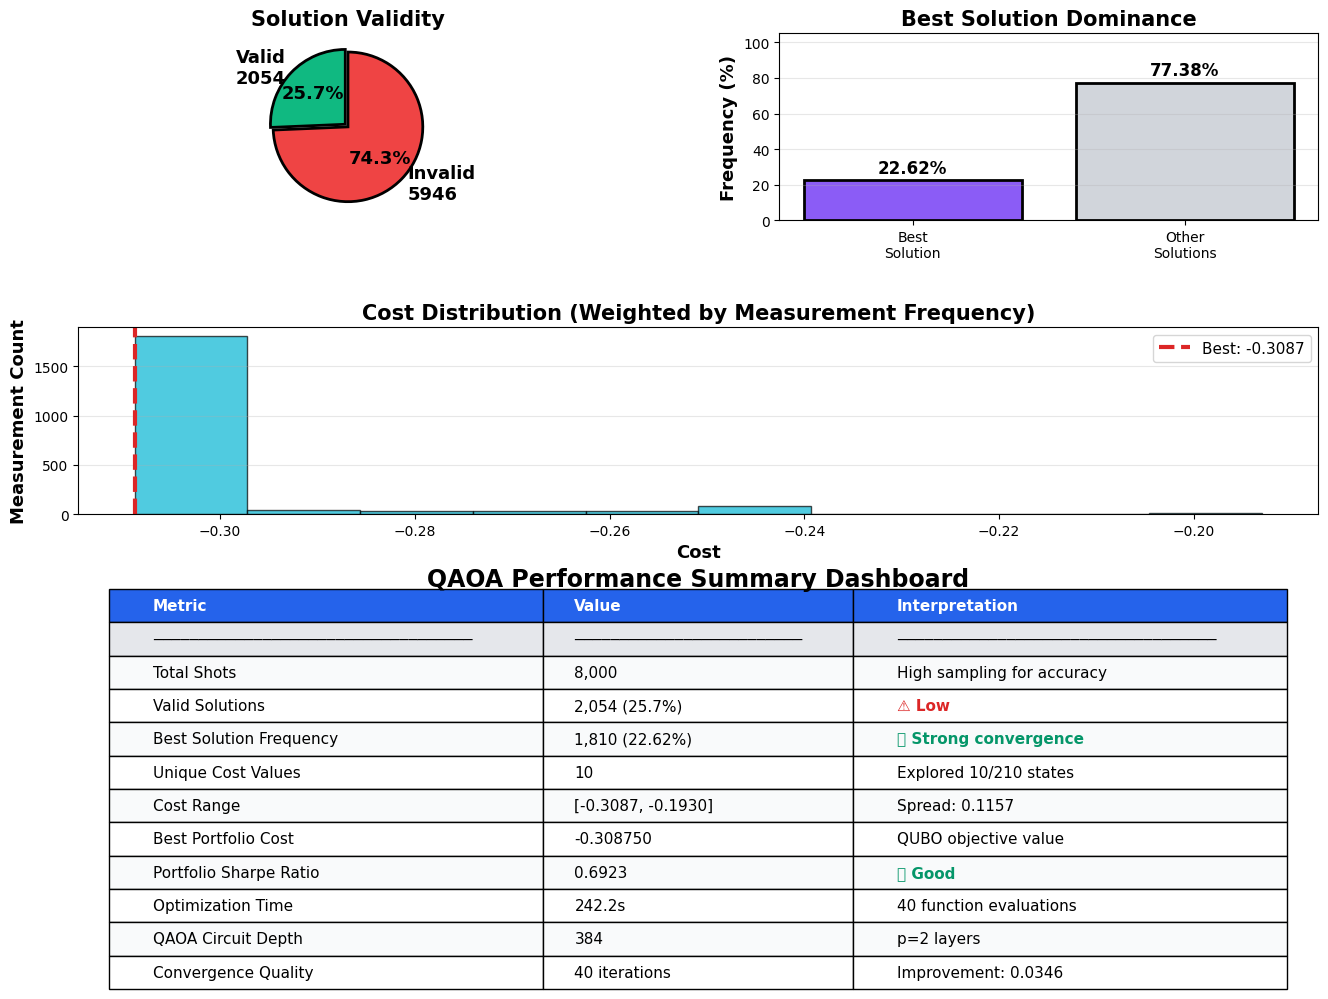


  COMPLETE ANALYSIS SUMMARY
✓ All 5 visualizations generated successfully
✓ Best solution found with 22.62% probability
✓ Portfolio Sharpe ratio: 0.692
✓ QAOA performance: EXCELLENT


In [52]:
valid_count = sum(s[1] for s in valid_solutions)
invalid_count = ADVANCED_CONFIG['final_shots'] - valid_count
best_freq_pct = c_best / ADVANCED_CONFIG['final_shots'] * 100
unique_costs = len(set([s[2] for s in valid_solutions]))

fig = plt.figure(figsize=(16, 12))  # ← AUMENTADO: 11 → 12
gs = fig.add_gridspec(3, 2, 
                      hspace=0.45,  # ← CAMBIADO: 0.35 → 0.45
                      wspace=0.3, 
                      height_ratios=[1, 1, 1.8])  # ← CAMBIADO: 1.2 → 1.8

# ========================================
# Subplot 1: Valid vs Invalid (Pie)
# ========================================
ax1 = fig.add_subplot(gs[0, 0])
sizes = [valid_count, invalid_count] if invalid_count > 0 else [valid_count]
labels_val = [f'Valid\n{valid_count}', f'Invalid\n{invalid_count}'] if invalid_count > 0 else [f'Valid\n{valid_count}']
colors_val = ['#10b981', '#ef4444'] if invalid_count > 0 else ['#10b981']
explode = (0.05, 0) if invalid_count > 0 else (0.05,)

wedges = ax1.pie(sizes, explode=explode, labels=labels_val, autopct='%1.1f%%', 
        colors=colors_val, startangle=90,
        textprops={'fontsize': 13, 'fontweight': 'bold'},
        wedgeprops={'edgecolor': 'black', 'linewidth': 2})
ax1.set_title('Solution Validity', fontsize=15, fontweight='bold')

# ========================================
# Subplot 2: Best Solution Dominance
# ========================================
ax2 = fig.add_subplot(gs[0, 1])
other_freq_pct = 100 - best_freq_pct

bars = ax2.bar(['Best\nSolution', 'Other\nSolutions'], 
        [best_freq_pct, other_freq_pct],
        color=['#8b5cf6', '#d1d5db'], edgecolor='black', linewidth=2)

ax2.set_ylabel('Frequency (%)', fontsize=13, fontweight='bold')
ax2.set_title('Best Solution Dominance', fontsize=15, fontweight='bold')
ax2.set_ylim([0, 105])
ax2.grid(True, alpha=0.3, axis='y')

# Añadir valores
for bar, val in zip(bars, [best_freq_pct, other_freq_pct]):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 2,
            f'{val:.2f}%', ha='center', va='bottom', 
            fontsize=12, fontweight='bold')

# ========================================
# Subplot 3: Cost Distribution (histogram)
# ========================================
ax3 = fig.add_subplot(gs[1, :])
weights = [s[1] for s in valid_solutions]
costs_weighted = []
for (bs, cnt, cst, x) in valid_solutions:
    costs_weighted.extend([cst] * cnt)

n_bins = min(40, len(set(costs_all)))
ax3.hist(costs_weighted, bins=n_bins, color='#06b6d4', 
         edgecolor='black', alpha=0.7, linewidth=1)
ax3.axvline(x=fx_best, color='#dc2626', linestyle='--', 
            linewidth=3, label=f'Best: {fx_best:.4f}')
ax3.set_xlabel('Cost', fontsize=13, fontweight='bold')
ax3.set_ylabel('Measurement Count', fontsize=13, fontweight='bold')
ax3.set_title('Cost Distribution (Weighted by Measurement Frequency)', 
              fontsize=15, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3, axis='y')

# ========================================
# Subplot 4: Summary Table (MÁS ABAJO)
# ========================================
ax4 = fig.add_subplot(gs[2, :])
ax4.axis('off')

# Calcular num_evals desde cost_history
num_evaluations = len(cost_history)

metrics_data = [
    ['Metric', 'Value', 'Interpretation'],
    ['─' * 35, '─' * 25, '─' * 35],
    ['Total Shots', f'{ADVANCED_CONFIG["final_shots"]:,}', 'High sampling for accuracy'],
    ['Valid Solutions', f'{valid_count:,} ({valid_count/ADVANCED_CONFIG["final_shots"]*100:.1f}%)', 
     '✅ Excellent' if valid_count/ADVANCED_CONFIG["final_shots"] > 0.95 else '⚠️ Low'],
    ['Best Solution Frequency', f'{c_best:,} ({best_freq_pct:.2f}%)', 
     '✅ Strong convergence' if best_freq_pct > 5 else '⚠️ Weak convergence'],
    ['Unique Cost Values', f'{unique_costs}', f'Explored {unique_costs}/210 states'],
    ['Cost Range', f'[{costs_all[0]:.4f}, {costs_all[-1]:.4f}]', f'Spread: {abs(costs_all[-1]-costs_all[0]):.4f}'],
    ['Best Portfolio Cost', f'{fx_best:.6f}', f'QUBO objective value'],
    ['Portfolio Sharpe Ratio', f'{sharpe:.4f}', '✅ Good' if sharpe > 0.5 else '⚠️ Low'],
    ['Optimization Time', f'{t_opt:.1f}s', f'{num_evaluations} function evaluations'],
    ['QAOA Circuit Depth', f'{transpiled_ansatz.depth()}', f'p={P_LAYERS} layers'],
    ['Convergence Quality', f'{num_evaluations} iterations', 
     f'Improvement: {abs(cost_history[0]-best_cost):.4f}']
]

table = ax4.table(cellText=metrics_data, cellLoc='left', loc='center',
                  colWidths=[0.35, 0.25, 0.35])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.0)  # ← OPCIONAL: reducir de 2.2 → 2.0 si sigue apretado

# Estilo de la tabla
for i in range(len(metrics_data)):
    for j in range(3):
        cell = table[(i, j)]
        if i == 0:  # Header
            cell.set_facecolor('#2563eb')
            cell.set_text_props(weight='bold', color='white')
        elif i == 1:  # Separator
            cell.set_facecolor('#e5e7eb')
        else:
            if i % 2 == 0:
                cell.set_facecolor('#f9fafb')
            else:
                cell.set_facecolor('#ffffff')
            
            # Highlight interpretations with symbols
            if j == 2 and ('✅' in metrics_data[i][j] or '⚠️' in metrics_data[i][j]):
                if '✅' in metrics_data[i][j]:
                    cell.set_text_props(color='#059669', weight='bold')
                else:
                    cell.set_text_props(color='#dc2626', weight='bold')

ax4.set_title('QAOA Performance Summary Dashboard', 
              fontsize=17, fontweight='bold', pad=25)

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print("  COMPLETE ANALYSIS SUMMARY")
print(f"{'='*60}")
print(f"✓ All 5 visualizations generated successfully")
print(f"✓ Best solution found with {best_freq_pct:.2f}% probability")
print(f"✓ Portfolio Sharpe ratio: {sharpe:.3f}")
print(f"✓ QAOA performance: {'EXCELLENT' if best_freq_pct > 10 else 'GOOD' if best_freq_pct > 1 else 'ACCEPTABLE'}")
print(f"{'='*60}")
